In [54]:
import glob
import itertools
import math
import os
import re
import sys
import warnings
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from scipy.stats import entropy, kruskal, pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.cm import get_cmap

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

In [62]:
sys.path.append(os.path.abspath('..'))

# **Data preparation**

## Initial data

TCGA AIRR and metadata tables are currently unavailable for publication.

The initial data contains:
1. An AIRR table:
 - `file.name`
 - `sample`: TCGA sample identifier
 - `locus`: TCR/BCR receptor gene locus (IGH, IGK, IGL, TRA, TRB, TRD, TRG)
 - `v_call`: Assigned V (variable) gene segment used in the receptor
 - `j_call`: Assigned J (joining) gene segment
 - `c_call`: Assigned C (constant) gene segment
 - `junction`: Nucleotide sequence of the V(D)J junction, including the CDR3 region
 - `junction_aa`: Amino acid translation of the junction sequence, representing the CDR3
 - `duplicate_count`: Number of times this exact clonotype sequence was observed in the sample (i.e., clone size or abundance)
 
 2. A meatdata table:
 
- `project_id`: TCGA project code 
- `case_id`: Unique patient identifier (UUID)
- `submitter_id`: TCGA sample identifier
- `file_name`
- `file_path`
- `normal`: Binary indicator (0/1) of whether the sample is from normal tissue
- `cancer`: Binary indicator (0/1) of whether the sample is from tumor tissue.
- `PASS`: Binary QC flag indicating whether the sample passed processing filters.
- `downloaded`: Binary indicator of successful file retrieval.
- `gender`: Biological sex of the patient (male/female).
- `year_of_birth`: Calendar year of patient’s birth (if available)
- `race`: Patient-reported race
- `ethnicity`: Patient-reported ethnicity
- `year_of_death`: Year of death, if applicable
- `classification_of_tumor`: Broad classification of the tumor type
- `last_known_disease_status`: Clinical assessment of disease status at the time of last follow-up
- `primary_diagnosis`: Main histopathological diagnosis
- `tumor_stage`: Stage of the tumor at diagnosis
- `age_at_diagnosis`: Patient’s age in years at the time of diagnosis
- `vital_status`: Whether the patient was alive or deceased at last follow-up
- `morphology`: Histological tumor type
- `days_to_death`: Time in days from diagnosis to death (if applicable)
- `days_to_last_known_disease_status`: Days from diagnosis to last recorded disease status
- `days_to_recurrence`: Time in days until tumor recurrence (if reported)
- `tumor_grade`: Tumor grade, indicating aggressiveness
- `tissue_or_organ_of_origin`: Anatomical origin of the tumor (e.g., Brain)
- `days_to_birth`: Patient age at diagnosis (negative value in days)
- `progression_or_recurrence`: Whether disease progression or recurrence was reported
- `prior_malignancy`: Whether the patient had any prior malignancies
- `site_of_resection_or_biopsy`: Anatomical site of sample collection (e.g., C71.9 for brain)
- `days_to_last_follow_up`: Time in days from diagnosis to last follow-up
- `therapeutic_agents`: Treatment(s) administered to the patient
- `treatment_intent_type`: Clinical goal of treatment 
- `treatment_or_therapy`: Binary or textual indicator of therapy received
- `sample_id`: Full sample identifier with replicate or aliquot suffix (e.g., TCGA-14-1823.1)
- `priority`: Custom priority flag


In [2]:
airr_df = pd.read_csv("~/airr_tables/tcga_airr_compiled.txt", sep="\t")
metadata_df = pd.read_csv("~/airr_tables/tcga_metadata.tsv", sep="\t")

In [3]:
airr_df.head(5)

file.name        sample locus  \
0  /projects/tcga/data/TCGA-02-0047.1.clonotypes....  TCGA-02-0047   IGH   
1  /projects/tcga/data/TCGA-02-0047.1.clonotypes....  TCGA-02-0047   IGH   
2  /projects/tcga/data/TCGA-02-0047.1.clonotypes....  TCGA-02-0047   IGH   
3  /projects/tcga/data/TCGA-02-0047.1.clonotypes....  TCGA-02-0047   IGH   
4  /projects/tcga/data/TCGA-02-0047.1.clonotypes....  TCGA-02-0047   IGH   

     v_call j_call c_call                                           junction  \
0  IGHV4-59  IGHJ4  IGHG1                  TGTGCGAGAGGCAGCTGGTACTTTGACTACTGG   
1  IGHV1-69  IGHJ3  IGHG1  TGTGCGAGAGGGAGCTGGAGGATGGAGCAAGTCCCCGAATTTAATG...   
2  IGHV3-33  IGHJ5  IGHG1   TGTGCGAGAGTCCCGGGGCCATTATTCAGCATGGTTCCGGACTACTGG   
3  IGHV3-49  IGHJ4  IGHG1  TGTACTAGAGCCCGGGGTATTATAGTCTCAGCTGGTATTTACTTTG...   
4  IGHV3-74  IGHJ3  IGHA1   TGTGCAAGAGTGTGGCGTGGGACCTACTGGGGTGGTTTTGATGTCTGG   

            junction_aa  duplicate_count  
0           CARGSWYFDYW                5  
1  CARGSWRMEQVPEFNDFNMW                2  
2      CARVPGPLFSMVPDYW                2  
3    CTRARGIIVSAGIYFDSW                2  
4      CARVWRGTYWGGFDVW                2

In [4]:
metadata_df.head(5)

project_id                               case_id  submitter_id  \
0   TCGA-GBM  a515cf2d-e918-4958-9bf6-e611b425a97e  TCGA-14-1823   
1   TCGA-GBM  6c28f086-6a25-40b6-93eb-bba0014acda6  TCGA-06-2557   
2   TCGA-GBM  7cada85b-00b1-41e5-9924-e09eb077ad56  TCGA-06-0130   
3   TCGA-GBM  7340f325-579f-4b90-96aa-3a7b362129ca  TCGA-27-1834   
4   TCGA-GBM  8df94420-c736-4a36-b001-5dbe3dff17f0  TCGA-76-4926   

                                           file_name  \
0  fabdb2b7-2e32-42bc-aa6d-20cfefaa6ee3_gdc_realn...   
1  822e613b-6dc5-4309-a807-05ef9bfbc66e_gdc_realn...   
2  62055ec1-b5b9-4f5f-8e70-2c02b9b111e4_gdc_realn...   
3  ecad90d3-43c4-4190-894e-3b083036dad4_gdc_realn...   
4  1614aef5-0c38-46c9-8771-53f2126dcd1b_gdc_realn...   

                                           file_path  normal  cancer  PASS  \
0  /home/tim_ivanov/DATA/gdc_data/second/670d6825...       0       1     1   
1  /home/tim_ivanov/DATA/gdc_data/second/4e9c6e86...       0       1     1   
2  /home/tim_ivanov/DATA/gdc_data/second/0ec0d17e...       0       1     1   
3  /home/tim_ivanov/DATA/gdc_data/second/af70fa22...       0       1     1   
4  /home/tim_ivanov/DATA/gdc_data/second/2aa6832b...       0       1     0   

   downloaded  gender  ... days_to_birth progression_or_recurrence  \
0           1  female  ...      -21384.0              not reported   
1           1    male  ...      -27980.0              not reported   
2           1    male  ...      -19812.0              not reported   
3           1    male  ...      -20568.0              not reported   
4           1    male  ...      -25085.0              not reported   

  prior_malignancy site_of_resection_or_biopsy days_to_last_follow_up  \
0     not reported                       C71.9                  543.0   
1     not reported                       C71.9                   33.0   
2     not reported                       C71.9                  320.0   
3     not reported                       C71.9                 1008.0   
4     not reported                       C71.9                  138.0   

  therapeutic_agents treatment_intent_type treatment_or_therapy  \
0                 --                    --                   --   
1                 --                    --                   --   
2                 --                    --                   --   
3                 --                    --                   --   
4                 --                    --                   --   

        sample_id priority  
0  TCGA-14-1823.1        0  
1  TCGA-06-2557.1        0  
2  TCGA-06-0130.1        0  
3  TCGA-27-1834.1        0  
4  TCGA-76-4926.1        0  

[5 rows x 36 columns]

In [ ]:
clonotypes_df = airr_df.copy()
meta_df = metadata_df.copy()

meta_df = meta_df.drop_duplicates(subset=["submitter_id"])
merged_df = clonotypes_df.merge(meta_df, left_on="sample", right_on="submitter_id")

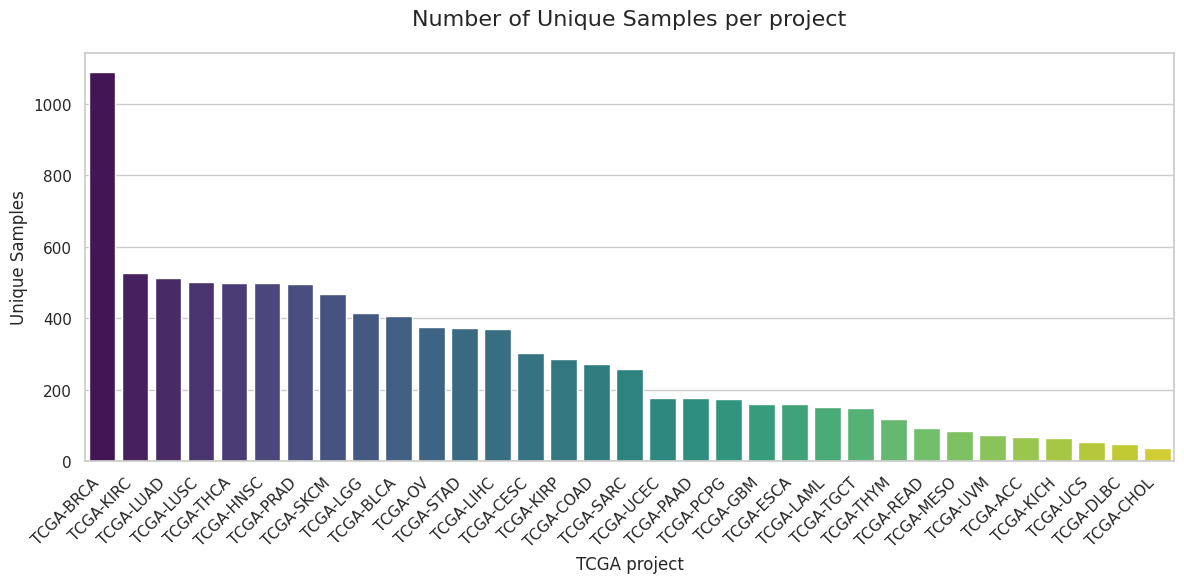

In [56]:
sample_counts = merged_df.groupby("project_id")["sample"].nunique().reset_index()
sample_counts.columns = ["project_id", "unique_samples"]
sample_counts = sample_counts.sort_values("unique_samples", ascending=False)

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=sample_counts,
    x="project_id",
    y="unique_samples",
    palette="viridis"
)

ax.set_title("Number of Unique Samples per project", fontsize=16, pad=20)
ax.set_xlabel("TCGA project", fontsize=12)
ax.set_ylabel("Unique Samples", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Preprocessing and normalization

- Creating pivot table with genes quantity in each sample
- Gene quantity normalization: gene duplicate count / sample duplicate count

In [5]:
sample_coverage = airr_df.groupby('sample')['duplicate_count'].sum()

In [6]:
def compute_normalized_table(df, column, sample_coverage):
    grouped = df.groupby(['sample', column])['duplicate_count'].sum().unstack(fill_value=0)
    normalized = grouped.div(sample_coverage, axis=0)
    return normalized

In [7]:
v_norm = compute_normalized_table(airr_df, 'v_call', sample_coverage)
j_norm = compute_normalized_table(airr_df, 'j_call', sample_coverage)
c_norm = compute_normalized_table(airr_df, 'c_call', sample_coverage)

cvj_table = pd.concat([v_norm, j_norm, c_norm], axis=1).fillna(0)
cvj_table = cvj_table.reset_index()
cvj_table = cvj_table.merge(
    metadata_df[["submitter_id", "project_id"]],
    left_on="sample",
    right_on="submitter_id",
    how="left"
)
cvj_table.drop(columns=["submitter_id"], inplace=True)
cvj_table = cvj_table.drop_duplicates()

In [8]:
cvj_table.head()

sample  IGHV1-12  IGHV1-17  IGHV1-18   IGHV1-2  IGHV1-24   IGHV1-3  \
0  TCGA-02-0047       0.0       0.0  0.010638  0.000000  0.000000  0.010638   
1  TCGA-02-0055       0.0       0.0  0.035406  0.000908  0.004539  0.003177   
2  TCGA-02-2483       0.0       0.0  0.000000  0.000000  0.000000  0.000000   
3  TCGA-02-2485       0.0       0.0  0.000000  0.000000  0.012821  0.000000   
4  TCGA-02-2486       0.0       0.0  0.002311  0.008475  0.000000  0.000000   

   IGHV1-45  IGHV1-46  IGHV1-58  ...  IGLC5  IGLC6     IGLC7      TRAC  \
0       0.0  0.000000  0.000000  ...    0.0    0.0  0.000000  0.000000   
1       0.0  0.004539  0.000000  ...    0.0    0.0  0.004539  0.000454   
2       0.0  0.000000  0.000000  ...    0.0    0.0  0.000000  0.016393   
3       0.0  0.000000  0.000000  ...    0.0    0.0  0.000000  0.051282   
4       0.0  0.000770  0.208783  ...    0.0    0.0  0.010786  0.004622   

      TRBC1     TRBC2  TRDC  TRGC1     TRGC2  project_id  
0  0.000000  0.000000   0.0    0.0  0.000000    TCGA-GBM  
1  0.002270  0.000454   0.0    0.0  0.000000    TCGA-GBM  
2  0.008197  0.000000   0.0    0.0  0.000000    TCGA-GBM  
3  0.089744  0.025641   0.0    0.0  0.012821    TCGA-GBM  
4  0.007704  0.003082   0.0    0.0  0.000000    TCGA-GBM  

[5 rows x 433 columns]

- dataframes for every locus
- dataframe for IG heavy chain genes is grouped by isotype

In [9]:
cols_dict = {}
for col in cvj_table.drop(columns = ['sample', 'project_id']).columns.tolist():
    prefix = col[:4] 
    if prefix in cols_dict:
        cols_dict[prefix].append(col)
    else:
        cols_dict[prefix] = [col]

In [10]:
ighv_df = cvj_table[["sample"] + cols_dict["IGHV"] + ['project_id']]
igkv_df = cvj_table[["sample"] + cols_dict["IGKV"] + ['project_id']]
iglv_df = cvj_table[["sample"] + cols_dict["IGLV"] + ['project_id']]
tcr_v_df = cvj_table[["sample"] + cols_dict["TRAV"] + cols_dict["TRBV"] + cols_dict["TRDV"] + cols_dict["TRGV"] + ['project_id']]
tcr_j_df = cvj_table[["sample"] + cols_dict["TRAJ"] + cols_dict["TRBJ"] + cols_dict["TRDJ"] + cols_dict["TRGJ"] + ['project_id']]

In [11]:
igh_df = cvj_table[["sample"] + cols_dict["IGHA"] + cols_dict["IGHD"] + cols_dict["IGHE"] + cols_dict["IGHG"] + cols_dict["IGHM"] + ['project_id']]

grouped_igh = {}
for col in igh_df.columns:
    prefix = col[:4]
    if prefix in grouped_igh:
        grouped_igh[prefix] += igh_df[col]
    else:
        grouped_igh[prefix] = igh_df[col].copy()

igh_df_grouped = pd.DataFrame(grouped_igh)

ig_df_grouped = igh_df_grouped.rename(columns={'samp': 'sample', 'dupl': 'duplicate_count', 'proj': 'project_id'})

In [12]:
ig_df_grouped.head()

sample      IGHA      IGHD  IGHE      IGHG      IGHM project_id
0  TCGA-02-0047  0.031915  0.000000   0.0  0.148936  0.010638   TCGA-GBM
1  TCGA-02-0055  0.085792  0.000908   0.0  0.187472  0.002724   TCGA-GBM
2  TCGA-02-2483  0.049180  0.000000   0.0  0.040984  0.000000   TCGA-GBM
3  TCGA-02-2485  0.038462  0.000000   0.0  0.038462  0.000000   TCGA-GBM
4  TCGA-02-2486  0.016179  0.000000   0.0  0.239599  0.006163   TCGA-GBM

# **Pearson correlation analysis**

- `correlation_table_maker_cross` and `process_localizations` functions create a separate `.csv` tables for each `project_id` with correaltion data between genes in locus dataframes
- `make_clustermaps` and `make_heatmaps` functions create plots based on calculated tables

In [13]:
from scripts.correlation_functions import (
    correlation_table_maker_cross,
    process_localizations,
    make_clustermaps,
    make_heatmaps,
    plot_similarity_clustermap
)

In [27]:
# calculating correlations
process_localizations(tcr_v_df, ighv_df, "plots/correlation_plots/tcr_ighv/")
process_localizations(tcr_v_df, iglv_df, "plots/correlation_plots/tcr_iglv/")
process_localizations(tcr_v_df, igkv_df, "plots/correlation_plots/tcr_igkv/")
process_localizations(tcr_v_df, ig_df_grouped, "plots/correlation_plots/tcr_ig/")
process_localizations(tcr_v_df, tcr_j_df, "plots/correlation_plots/tcr_v_j/")

# making clustermaps
make_clustermaps("plots/correlation_plots/tcr_ighv/")
make_clustermaps("plots/correlation_plots/tcr_iglv/")
make_clustermaps("plots/correlation_plots/tcr_igkv/")
make_clustermaps("plots/correlation_plots/tcr_ig/")
make_clustermaps("plots/correlation_plots/tcr_v_j/")

# making heatmaps
make_heatmaps("plots/correlation_plots/tcr_ighv/")
make_heatmaps("plots/correlation_plots/tcr_iglv/")
make_heatmaps("plots/correlation_plots/tcr_igkv/")
make_heatmaps("plots/correlation_plots/tcr_ig/")
make_heatmaps("plots/correlation_plots/tcr_v_j/")


All obtained plots are available in `plots/correaltion_plots/` directory.

Example plots for correlations of IGH V-genes and TCR V-genes in DLBC project. Insighnificant correaltions (p-value adjusted > 0.05) are masked with gray.

![project1 clustermap](../plots/correlation_plots/tcr_ighv/clustermaps/TCGA-DLBC_cor.png)

![project1 clustermap](../plots/correlation_plots/tcr_ighv/heatmaps/TCGA-DLBC_heatmap.png)

## Shared sighnificant correlations

Heatmaps of shared sighnificant correlations between TCGA projects. The number of shared significant pairs between two diagnoses is normalized by dividing it by the square root of the average total number of significant pairs in both diagnoses.

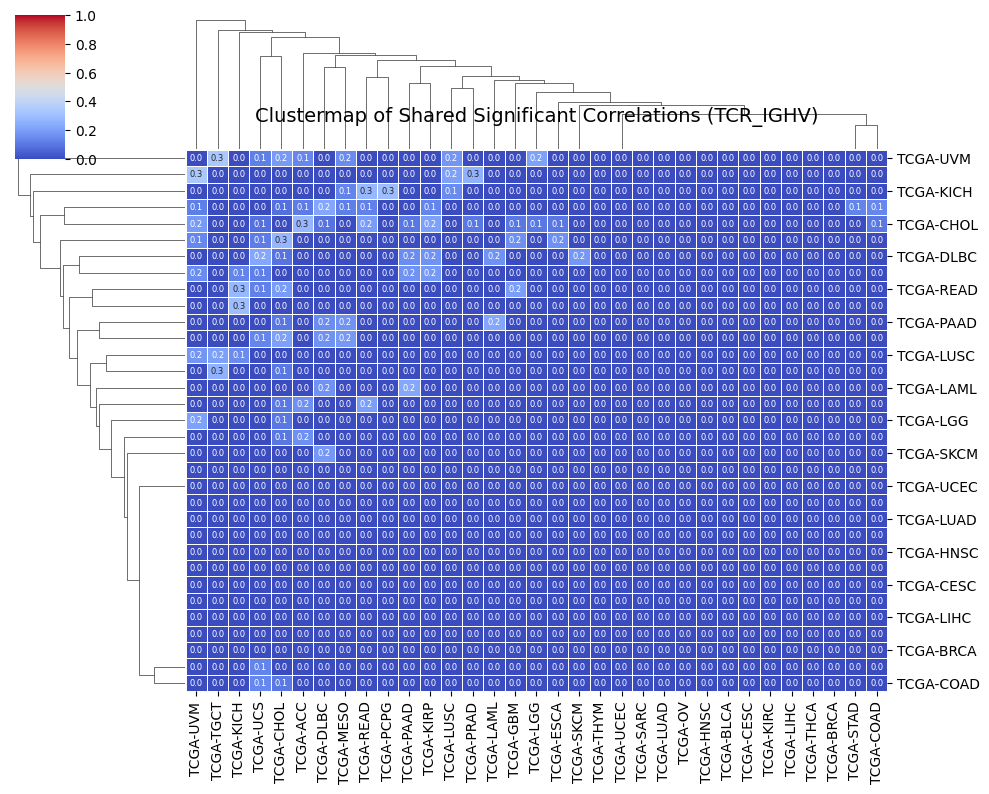

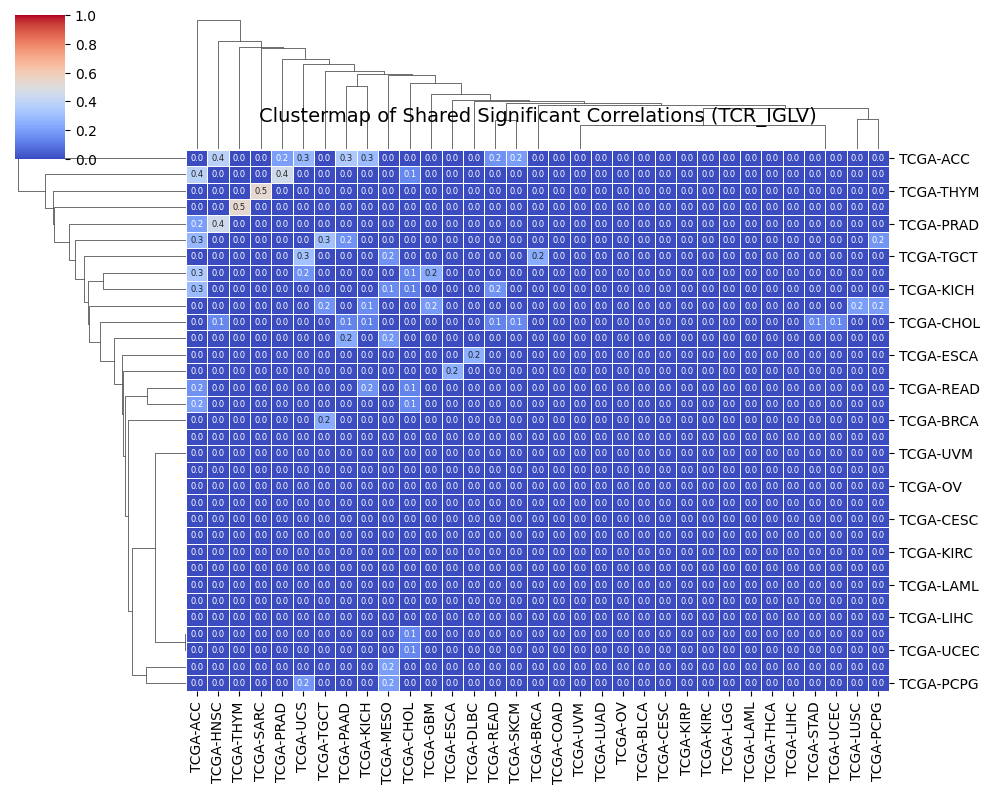

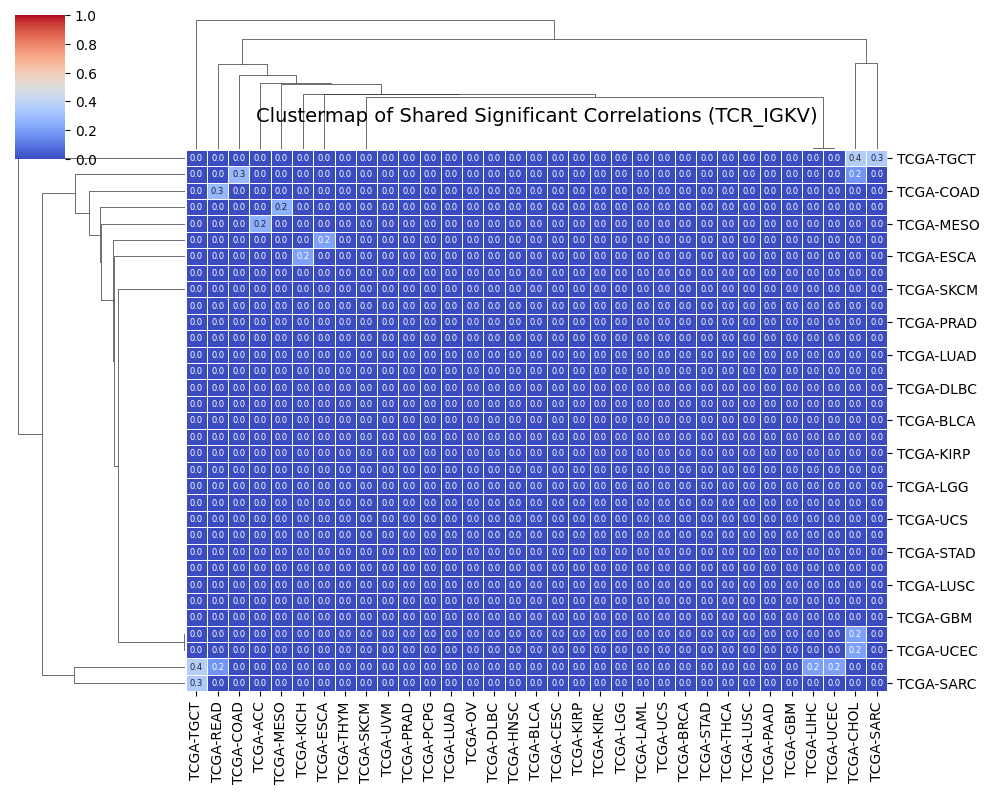

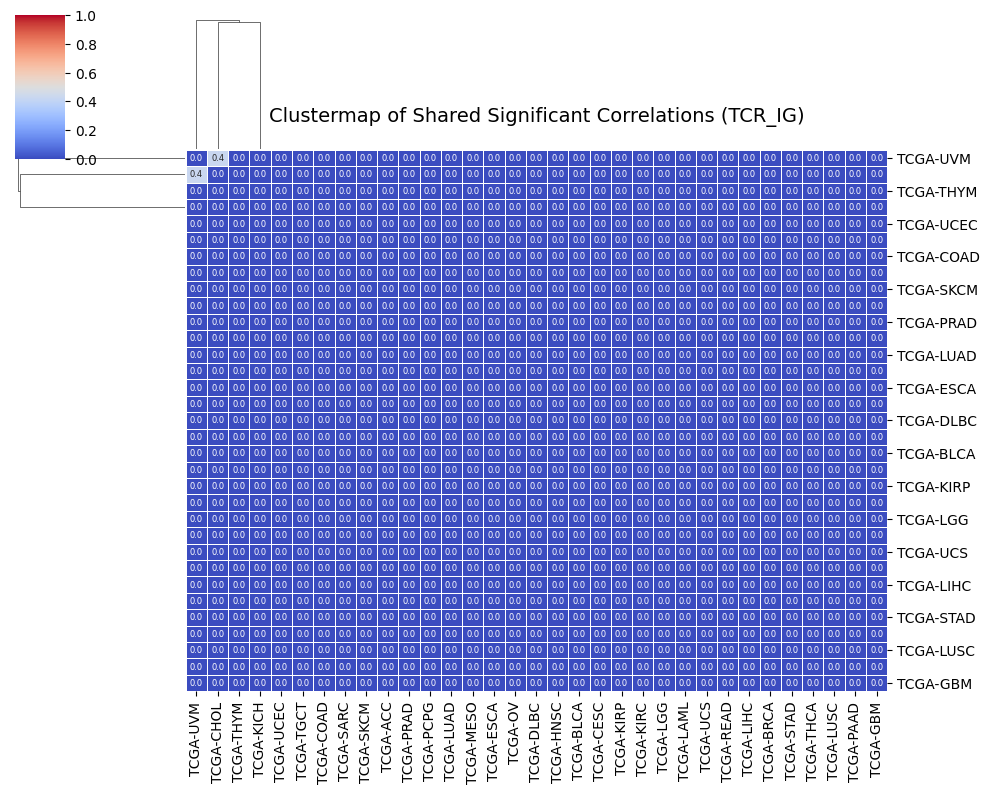

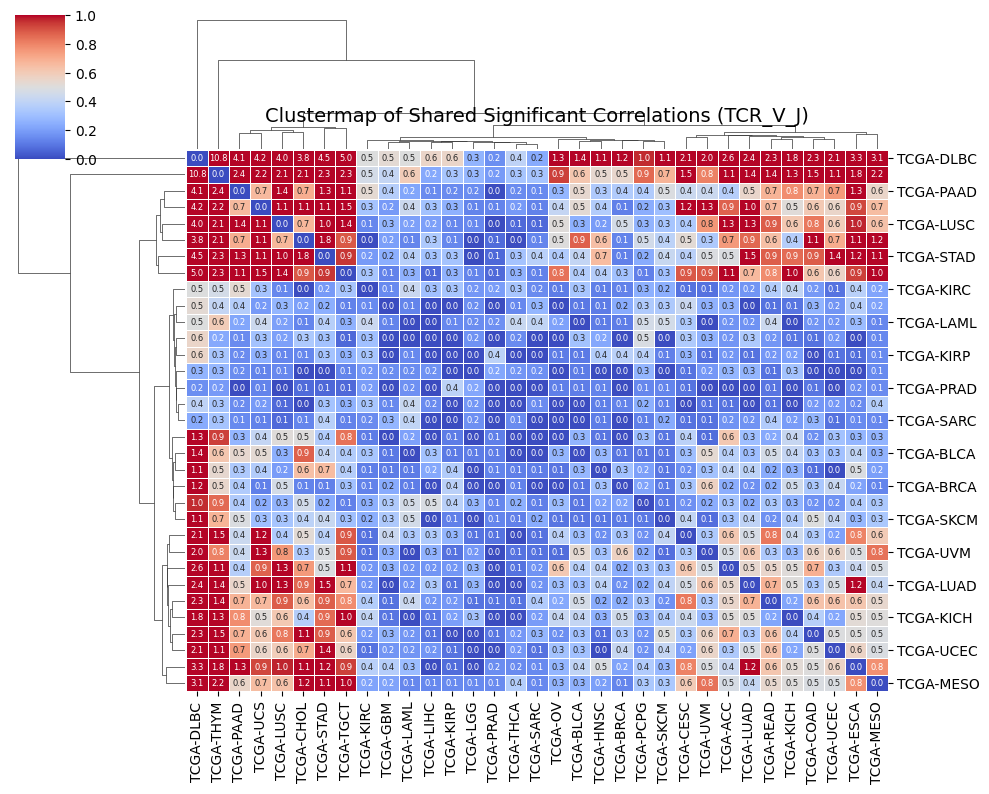

In [16]:
groups = ["tcr_ighv", "tcr_iglv", "tcr_igkv", "tcr_ig", "tcr_v_j"]

for group in groups:
    group_dir = f"plots/correlation_plots/{group}/"
    title = f"Clustermap of Shared Significant Correlations ({group.upper()})"
    plot_similarity_clustermap(group_dir, title)

# **TRDV isotypes proportions in TCGA projects**

In [43]:
trdv_genes = ["TRDV1", "TRDV2", "TRDV3"]
filtered_df = merged_df[merged_df["v_call"].isin(trdv_genes)].copy()

total_counts = filtered_df.groupby("project_id")["duplicate_count"].sum().reset_index()
total_counts = total_counts.rename(columns={"duplicate_count": "total_project_count"})

agg_df = filtered_df.groupby(["project_id", "v_call"])["duplicate_count"].sum().reset_index()
agg_df = agg_df.merge(total_counts, on="project_id")

agg_df["percentage"] = agg_df["duplicate_count"] / agg_df["total_project_count"] * 100

agg_df["p_raw"] = agg_df["percentage"] / 100
agg_df["se"] = np.sqrt(agg_df["p_raw"] * (1 - agg_df["p_raw"]) / agg_df["total_project_count"]) * 100 

projects = agg_df["project_id"].unique()
complete_index = pd.MultiIndex.from_product([projects, trdv_genes], names=["project_id", "v_call"])
agg_df = agg_df.set_index(["project_id", "v_call"]).reindex(complete_index, fill_value=0).reset_index()

agg_df["p_raw"] = agg_df["percentage"] / 100
agg_df["se"] = np.where(agg_df["duplicate_count"] == 0, 0,
                        np.sqrt(agg_df["p_raw"] * (1 - agg_df["p_raw"]) / agg_df["total_project_count"]) * 100)

pivot_df = agg_df.pivot(index="project_id", columns="v_call", values="percentage").fillna(0).reset_index()

def entropy(p):
    p = p / 100  
    if p in [0, 1]:
        return 0
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

pivot_df["entropy_trdv2"] = pivot_df["TRDV2"].apply(entropy)

sorted_projects = pivot_df.sort_values("entropy_trdv2", ascending=False)["project_id"].tolist()


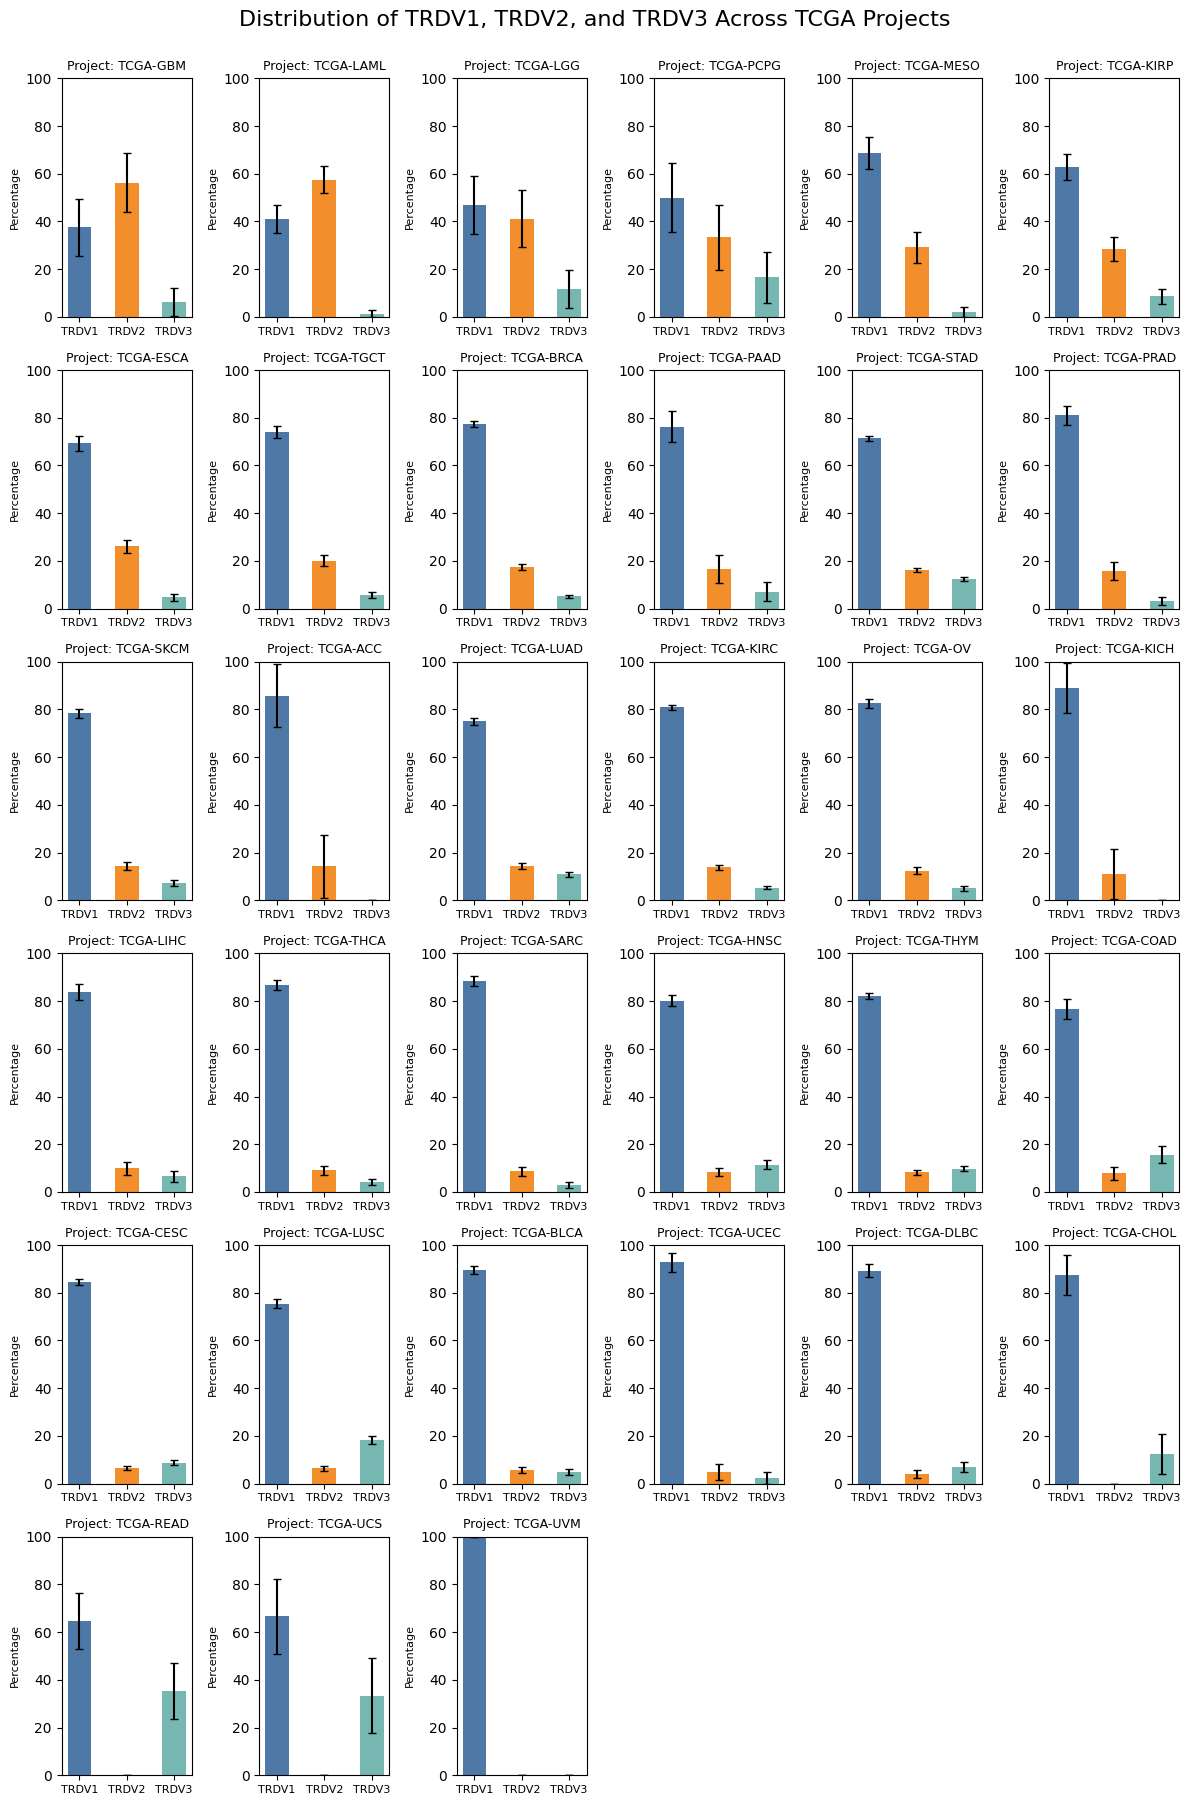

In [44]:
fig_cols = 6
fig_rows = int(np.ceil(len(sorted_projects) / fig_cols))
fig, axes = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(fig_cols * 2, fig_rows * 3))
axes = axes.flatten()

colors = {"TRDV1": "#4E79A7", "TRDV2": "#F28E2B", "TRDV3": "#76B7B2"}
bar_width = 0.5  

for i, project in enumerate(sorted_projects):
    proj_data = agg_df[agg_df["project_id"] == project]

    bars = []
    for j, gene in enumerate(trdv_genes):
        row = proj_data[proj_data["v_call"] == gene]
        val = row["percentage"].values[0]
        err = row["se"].values[0]
        bars.append(axes[i].bar(j, val, yerr=err, color=colors[gene], width=bar_width, capsize=3, label=gene))

    axes[i].set_xticks([0, 1, 2])
    axes[i].set_xticklabels(trdv_genes, fontsize=8)
    axes[i].set_ylim(0, 100)
    axes[i].set_title(f"Project: {project}", fontsize=9)
    axes[i].set_ylabel("Percentage", fontsize=8)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of TRDV1, TRDV2, and TRDV3 Across TCGA Projects", 
             fontsize=16, y=1)
plt.tight_layout()

# **MAIT cells proportions in TCGA projects**

In [48]:
mait_cells = merged_df[
    (merged_df["v_call"] == "TRAV1-2") &
    (merged_df["j_call"].isin(["TRAJ33", "TRAJ20", "TRAJ12"])) &
    (merged_df["junction_aa"].str.len() == 12)
]

mait_cancers = ['TCGA-BLCA', 'TCGA-CESC', 'TCGA-CHOL', 'TCGA-COAD', 
                'TCGA-ESCA', 'TCGA-HNSC', 'TCGA-LUAD', 'TCGA-LUSC',
                'TCGA-READ', 'TCGA-STAD', 'TCGA-UCEC', 'TCGA-UCS', 
                'TCGA-LAML', 'TCGA-LIHC', 'TCGA-SKCM']

In [50]:
mait_counts = mait_cells.groupby("project_id").size().reset_index(name="mait_count")
sample_counts = merged_df.groupby("project_id")["sample"].nunique().reset_index(name="n_samples")

merged_counts = mait_counts.merge(sample_counts, on="project_id")
merged_counts["mait_per_sample"] = merged_counts["mait_count"] / merged_counts["n_samples"]

merged_counts["involves MAIT-assoc. tissue"] = merged_counts["project_id"].apply(
    lambda x: "yes" if x in mait_cancers else "no"
)

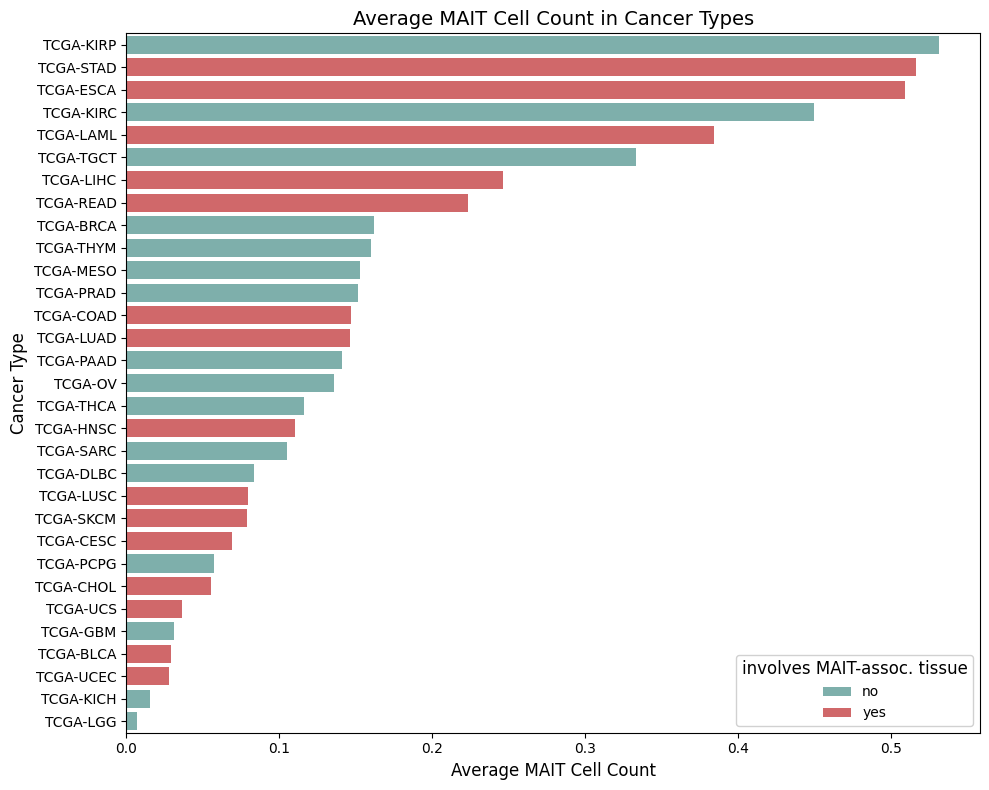

In [51]:
plt.figure(figsize=(10, 8))
sns.barplot(
    x="mait_per_sample", 
    y="project_id", 
    data=merged_counts.sort_values("mait_per_sample", ascending=False),  
    hue='involves MAIT-assoc. tissue', 
    dodge=False,
    palette={'yes': '#E15759', 'no': '#76B7B2'}
)

plt.title("Average MAIT Cell Count in Cancer Types", fontsize=14)
plt.xlabel("Average MAIT Cell Count", fontsize=12)
plt.ylabel("Cancer Type", fontsize=12)
plt.legend(title='involves MAIT-assoc. tissue', title_fontsize=12, fontsize=10,
           loc='lower right', frameon=True, facecolor='white', framealpha=0.9)
plt.tight_layout()
plt.show()

# **Shannon diversity analysis**

Plot of Shannon diversity index of TCR V genes and IGM proportion ratio in TCGA projects.

In [19]:
def compute_shannon(df, locus_filter, groupby_col="project_id"):
    df = df[df["locus"].isin(locus_filter)].copy()
    counts = df.groupby([groupby_col, "v_call"])["duplicate_count"].sum().reset_index()
    
    shannon_list = []
    for project in counts[groupby_col].unique():
        proj_data = counts[counts[groupby_col] == project]
        total = proj_data["duplicate_count"].sum()
        p_i = proj_data["duplicate_count"] / total
        p_i = p_i[p_i > 0]
        H = -np.sum(p_i * np.log(p_i))
        shannon_list.append({groupby_col: project, "shannon_index": H})
    return pd.DataFrame(shannon_list)

In [20]:
def compute_igm_ratio(df, groupby_col="project_id"):
    ig_df = df[df.c_call.str.startswith(("IGHA", "IGHM", "IGHG", "IGHD", "IGHE")).fillna(False)]
    ig_df["isotype_short"] = ig_df["c_call"].str[:4]
    isotype_counts = ig_df.groupby([groupby_col, "isotype_short"])["duplicate_count"].sum().reset_index()

    ratio_list = []
    for project in isotype_counts[groupby_col].unique():
        proj_data = isotype_counts[isotype_counts[groupby_col] == project]
        igm_count = proj_data[proj_data["isotype_short"] == "IGHM"]["duplicate_count"].sum()
        total_ig = proj_data["duplicate_count"].sum()
        rest_count = total_ig - igm_count
        ratio = igm_count / rest_count if rest_count > 0 else np.nan
        ratio_list.append({groupby_col: project, "igm_ratio": ratio})
    return pd.DataFrame(ratio_list)

In [21]:
def plot_scatter(combined_df, x_col, y_col, color_col="project_id", title="", exclude=[]):
    unique_projects = combined_df[color_col].unique()
    palette = sns.color_palette("tab20", len(unique_projects))
    project_color_map = dict(zip(unique_projects, palette))

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=combined_df[~combined_df[color_col].isin(exclude)],
        x=x_col, y=y_col, hue=color_col,
        palette=project_color_map, s=90, edgecolor='black')

    texts = []
    for _, row in combined_df[~combined_df[color_col].isin(exclude)].iterrows():
        text = plt.text(row[x_col], row[y_col], row[color_col], fontsize=8)
        texts.append(text)

    adjust_text(texts, expand_points=(1.2, 1.2), expand_text=(1.05, 1.05))

    plt.title(title, fontsize=14)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.legend(title="Cancer Type", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title_fontsize=9)
    plt.tight_layout()
    plt.show()

In [23]:
shannon_trav = compute_shannon(merged_df, locus_filter=["TRA"])
shannon_trbv = compute_shannon(merged_df, locus_filter=["TRB"])
shannon_all_v = compute_shannon(merged_df, locus_filter=["TRA", "TRB", "TRD", "TRG"])
igm_ratio_df = compute_igm_ratio(merged_df)

The TCGA-DLBC project (Diffuse Large B-cell Lymphoma) is excluded due to relatively very high IGM proportion.

- Plot for TRA V genes Shannon diversity

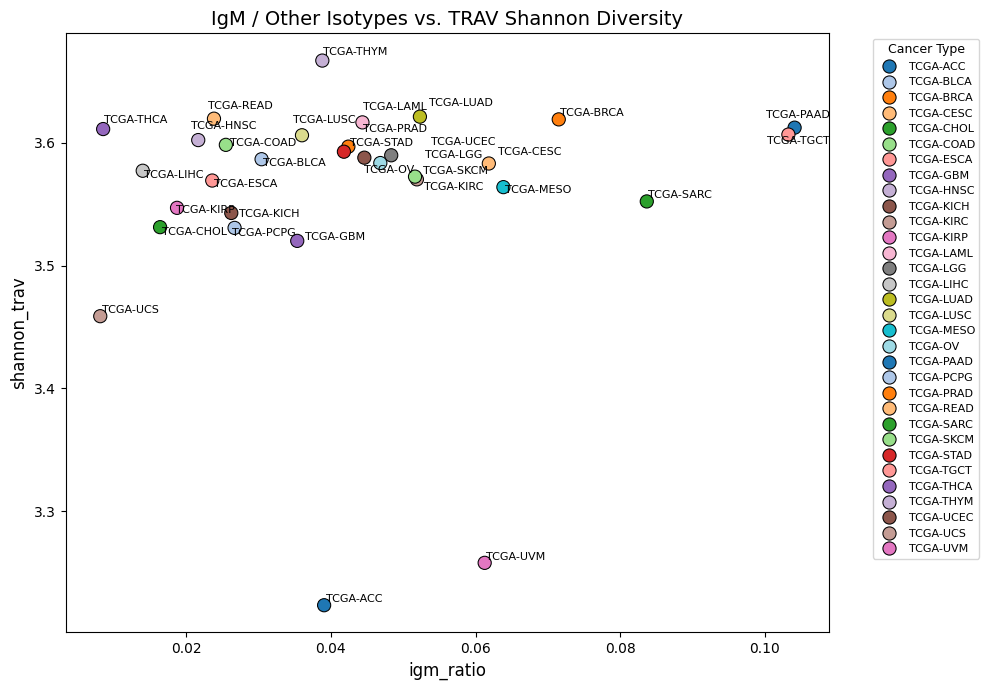

In [24]:
combined_df = pd.merge(shannon_trav, igm_ratio_df, on="project_id", how="inner")
combined_df = combined_df.rename(columns={"shannon_index": "shannon_trav"})

plot_scatter(
    combined_df,
    x_col="igm_ratio",
    y_col="shannon_trav",
    title="IgM / Other Isotypes vs. TRAV Shannon Diversity",
    exclude=["TCGA-DLBC"]
)

- Plot for TRB V genes Shannon diversity

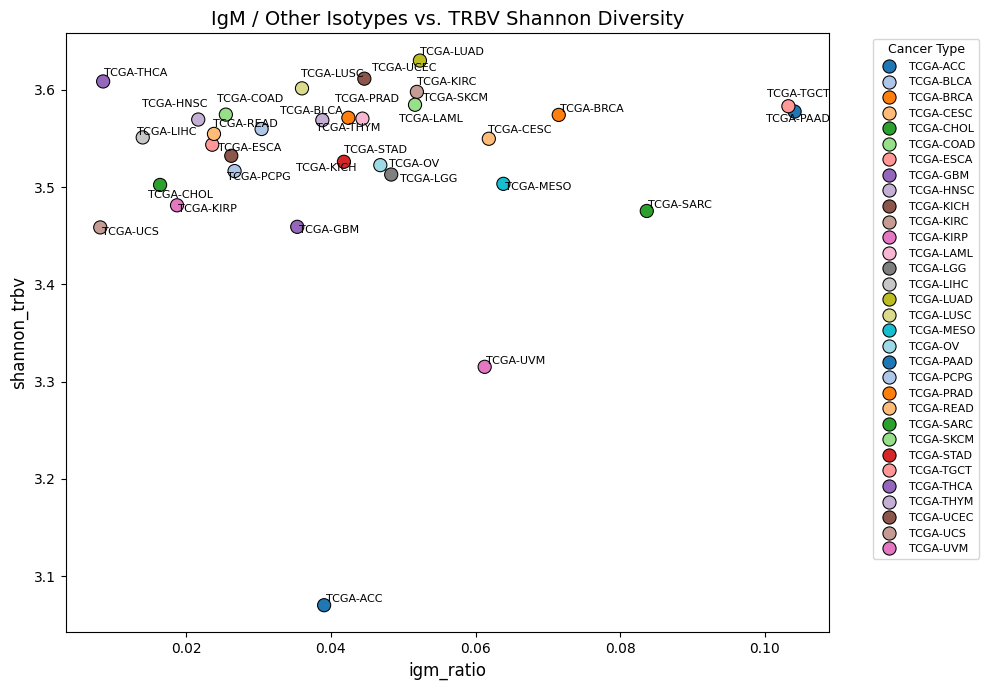

In [25]:
combined_df = pd.merge(shannon_trbv, igm_ratio_df, on="project_id", how="inner")
combined_df = combined_df.rename(columns={"shannon_index": "shannon_trbv"})

plot_scatter(
    combined_df,
    x_col="igm_ratio",
    y_col="shannon_trbv",
    title="IgM / Other Isotypes vs. TRBV Shannon Diversity",
    exclude=["TCGA-DLBC"]
)

- Plot for all TCR V genes Shannon diversity

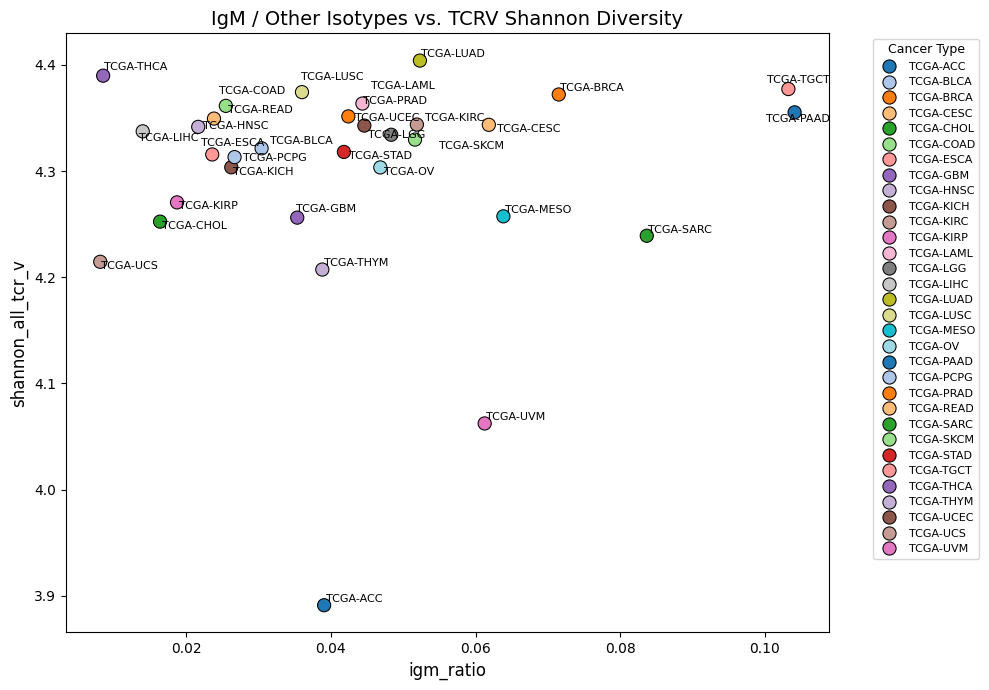

In [27]:
combined_df = pd.merge(shannon_all_v, igm_ratio_df, on="project_id", how="inner")
combined_df = combined_df.rename(columns={"shannon_index": "shannon_all_tcr_v"})

plot_scatter(
    combined_df,
    x_col="igm_ratio",
    y_col="shannon_all_tcr_v",
    title="IgM / Other Isotypes vs. TCRV Shannon Diversity",
    exclude=["TCGA-DLBC"]
)

# **Regression analysis**

- Heatmaps of regression coefficients of BCR genes ~ TCGA project 

In [63]:
from scripts.regression_functions import (
    analyze_gene_set_vs_cancer,
    analyze_bcr_tcr
)

## BCR genes ~ TCGA project

Scaling dataframes:

In [30]:
dfs = {
    "ighv_df": ighv_df,
    "igkv_df": igkv_df,
    "iglv_df": iglv_df,
    "tcr_v_df": tcr_v_df,
    "tcr_j_df": tcr_j_df,
    "ig_df_grouped": ig_df_grouped
}

scaled_dfs = {}

for name, df in dfs.items():
    df_copy = df.copy()
    features = [col for col in df_copy.columns if col != "sample" and col != "project_id"] 

    scaler = StandardScaler()
    df_copy[features] = scaler.fit_transform(df_copy[features])

    scaled_dfs[name] = df_copy

- IGH V genes ~ TCGA project

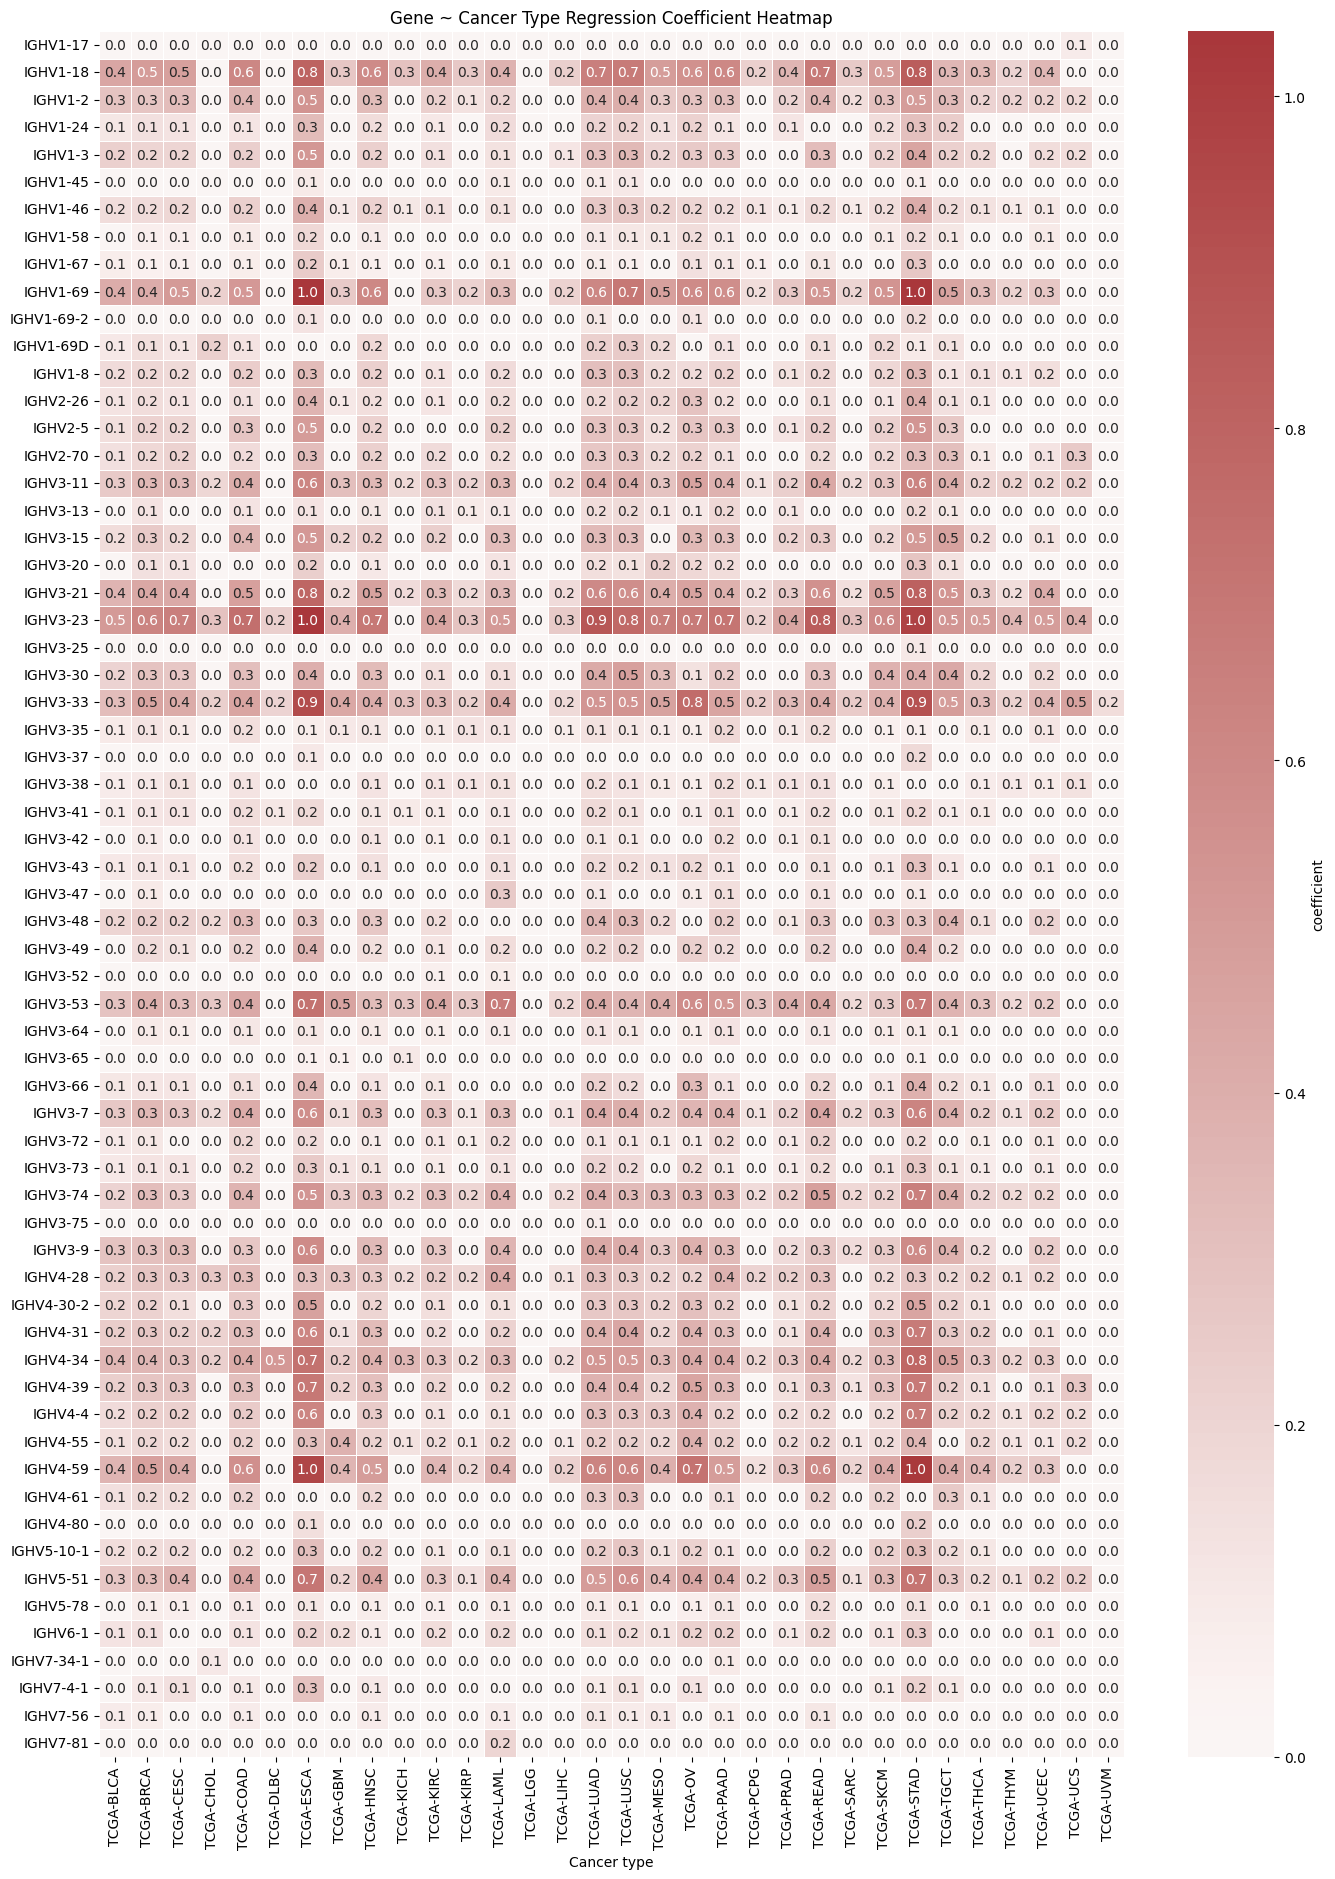

In [46]:
ighv_r = analyze_gene_set_vs_cancer(scaled_dfs["ighv_df"], output_csv="ighv_regr.csv", heatmap_file="plots/regression_plots/heatmap_ighv.png")

- IGK V genes ~ TCGA project

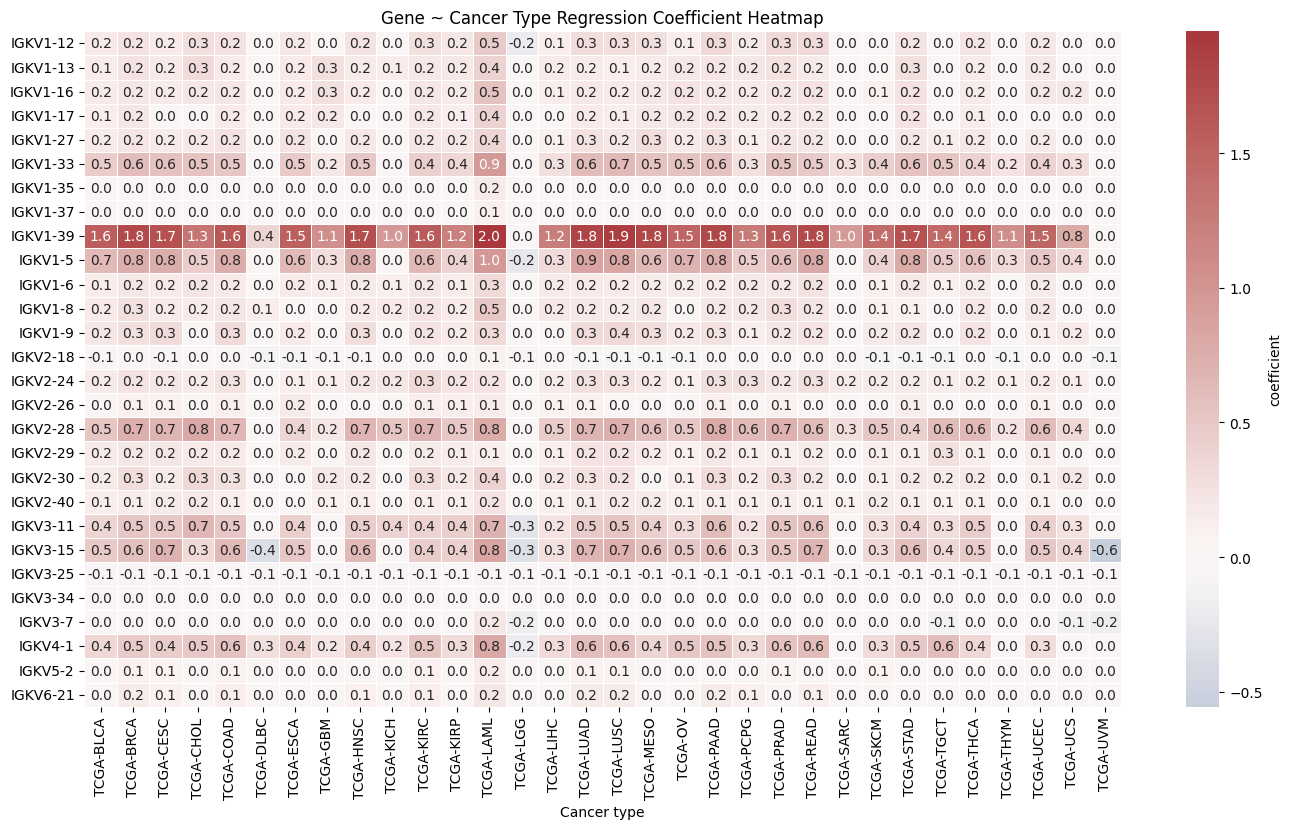

In [47]:
igkv_r = analyze_gene_set_vs_cancer(scaled_dfs["igkv_df"], output_csv="igkv_regr.csv", heatmap_file="plots/regression_plots/heatmap_igkv.png")

- IGL V genes ~ TCGA project

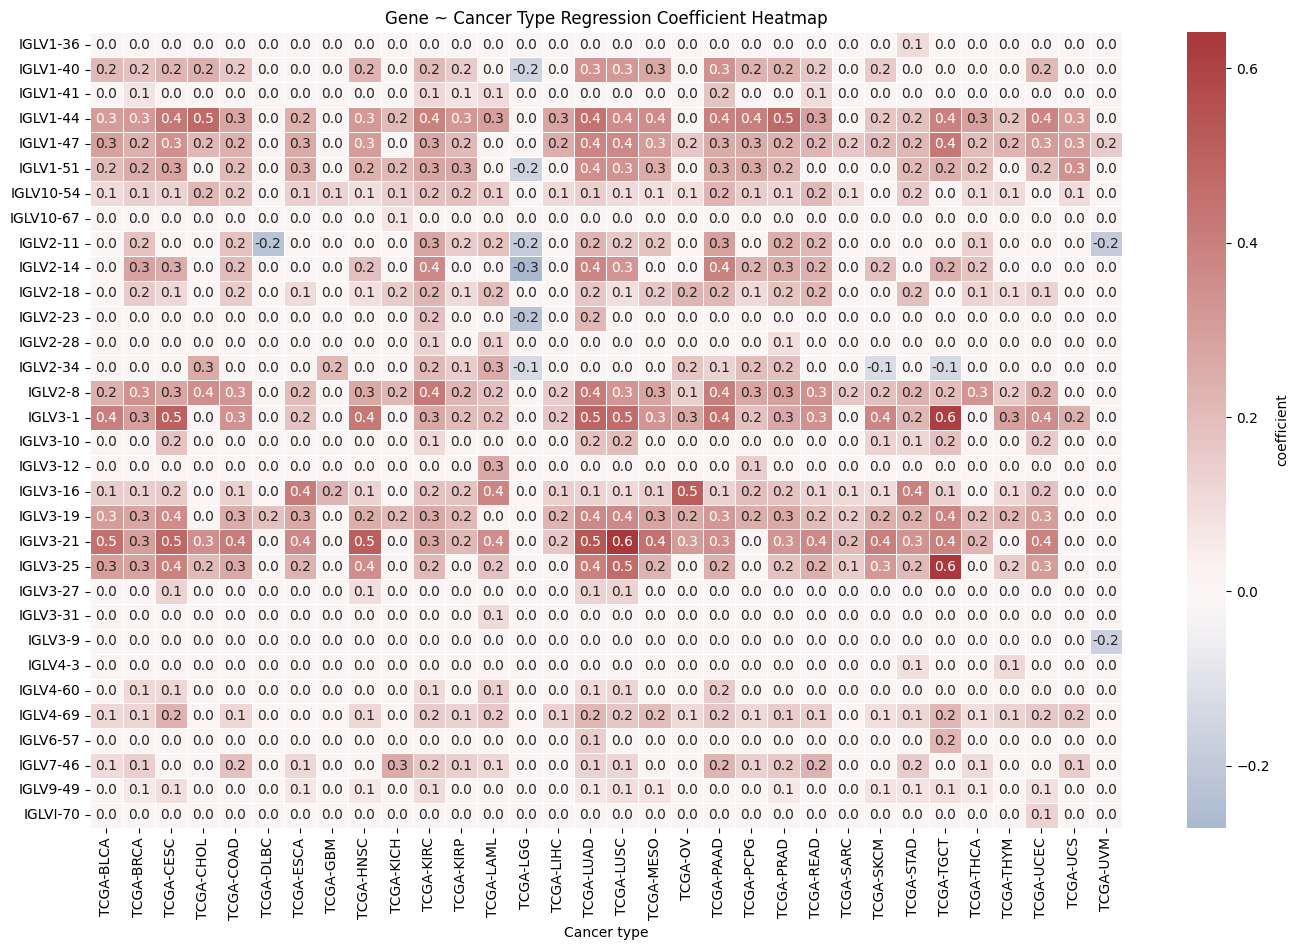

In [48]:
iglv_r = analyze_gene_set_vs_cancer(scaled_dfs["iglv_df"], output_csv="ighv_regr.csv", heatmap_file="plots/regression_plots/heatmap_iglv.png")

- IGH genes ~ TCGA project

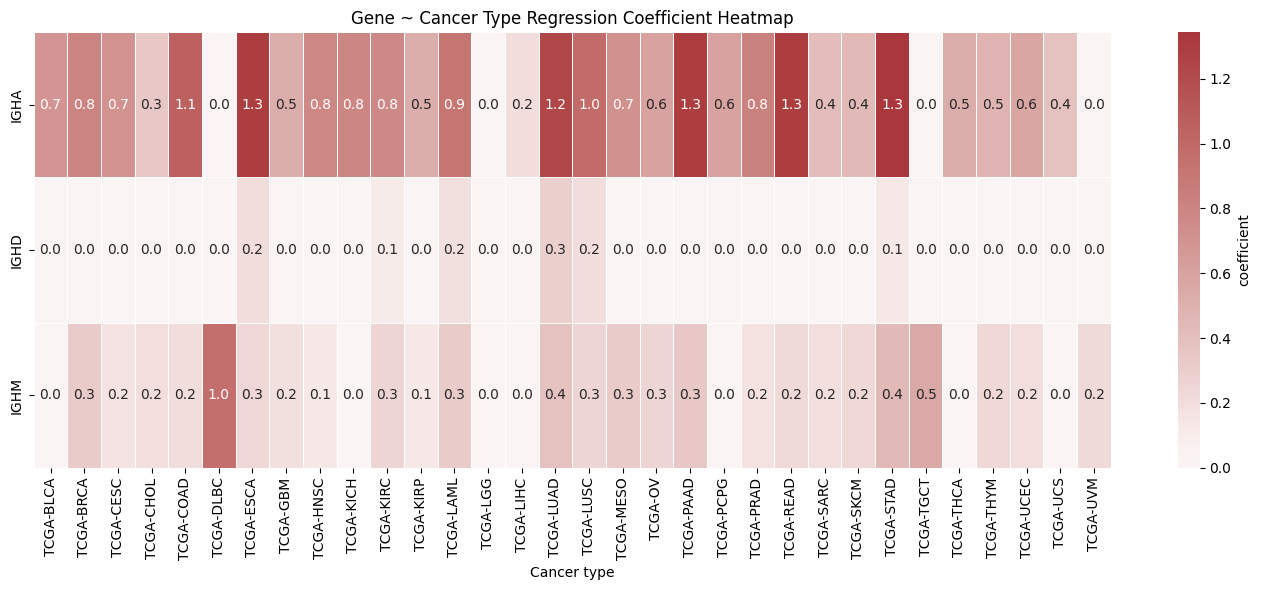

In [49]:
ig_r = analyze_gene_set_vs_cancer(scaled_dfs["ig_df_grouped"], output_csv="ig_regr.csv", heatmap_file="plots/regression_plots/heatmap_igh.png")

## BCR V genes ~ TCR V genes * TCGA project

In [ ]:
ighv_regr = analyze_bcr_tcr(ighv_df, tcr_v_df, output_csv="regr/ighv_tcr_regr.csv")
igkv_regr = analyze_bcr_tcr(igkv_df, tcr_v_df, output_csv="regr/igkv_tcr_regr.csv")
iglv_regr = analyze_bcr_tcr(iglv_df, tcr_v_df, output_csv="regr/iglv_tcr_regr.csv")
ig_regr = analyze_bcr_tcr(ig_df_grouped, tcr_v_df, output_csv="regr/ig_tcr_regr.csv")

In [32]:
ighv_regr = pd.read_csv("~/regr/ighv_tcr_regr.csv")
igkv_regr = pd.read_csv("~/regr/igkv_tcr_regr.csv")
iglv_regr = pd.read_csv("~/regr/iglv_tcr_regr.csv")
ig_regr = pd.read_csv("~/regr/ig_tcr_regr.csv")

- IG isotypes ~ TCR V gene x TCGA project

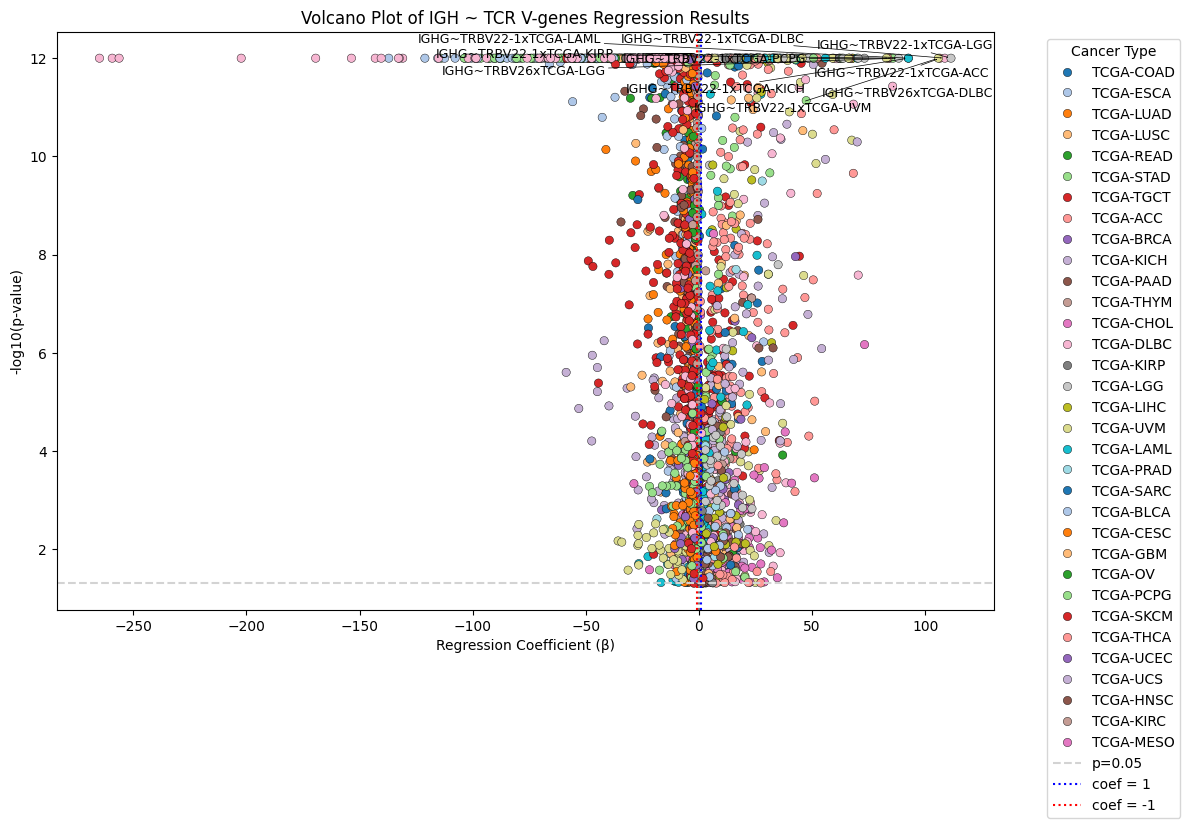

In [50]:
df = ig_regr.copy()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="coef", y="-log10(p-value)", hue="TCGA_predictor", palette="tab20", edgecolor="black", linewidth=0.3)

plt.axhline(-np.log10(0.05), color="lightgrey", linestyle="dashed", label="p=0.05")
plt.axvline(0, color="grey", linestyle="dotted")
plt.axvline(1, color="blue", linestyle="dotted", label="coef = 1")
plt.axvline(-1, color="red", linestyle="dotted", label="coef = -1")

plt.xlabel("Regression Coefficient (β)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot of IGH ~ TCR V-genes Regression Results")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cancer Type")

df_top10 = df.nlargest(10, "coef")
df_top1_cancer = df.sort_values("coef", ascending=False).groupby("TCGA_predictor").head(1)

highlight = pd.concat([df_top10, df_top1_cancer]).drop_duplicates()

texts = []
for i, row in df_top10.iterrows():
    label = f"{row['dependent_var']}~{row['gene_predictor']}x{row['TCGA_predictor']}"
    texts.append(
        plt.text(row["coef"], row["-log10(p-value)"], label, fontsize=9, ha='right')
    )

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))
plt.savefig("plots/regression_plots/volcano_plot_IGH_TCR.png", dpi=300, bbox_inches='tight') 
plt.tight_layout()
plt.show()

- IGH V genes isotypes ~ TCR V gene x TCGA project

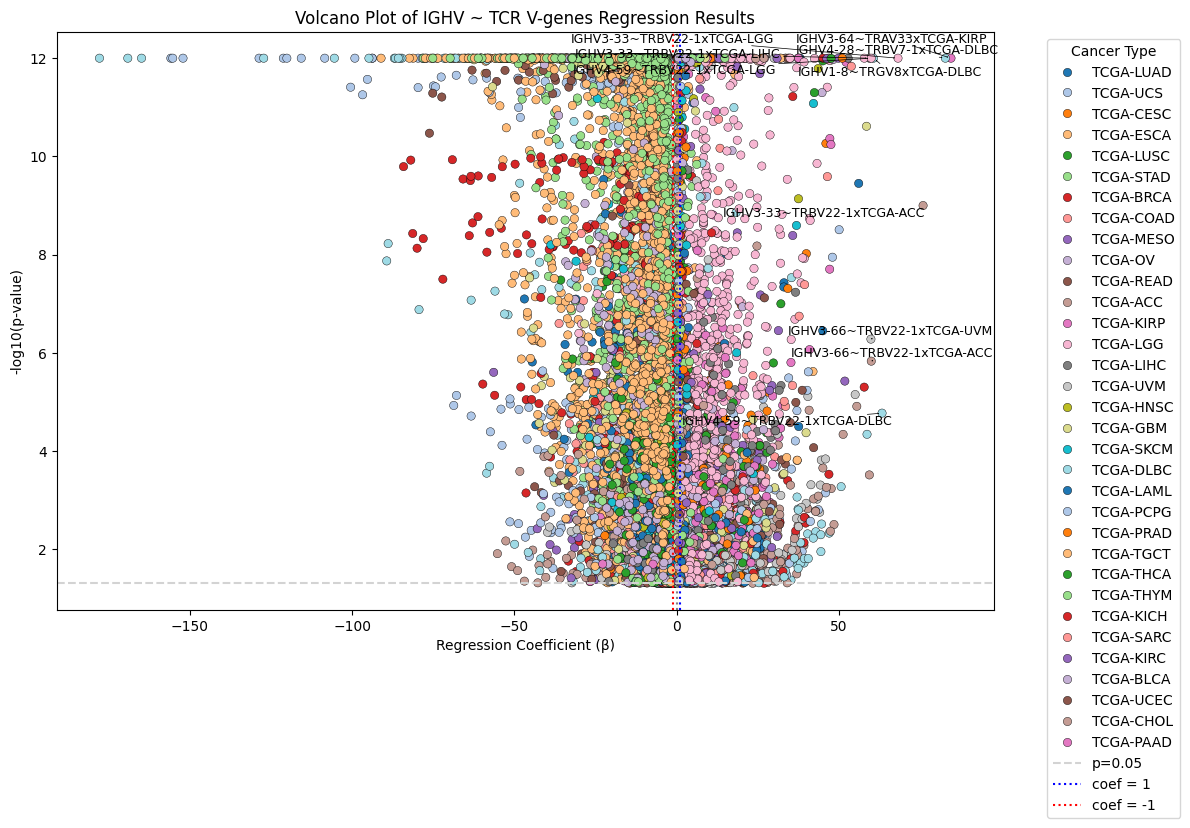

In [51]:
df = ighv_regr.copy()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="coef", y="-log10(p-value)", hue="TCGA_predictor", palette="tab20", edgecolor="black", linewidth=0.3)

plt.axhline(-np.log10(0.05), color="lightgrey", linestyle="dashed", label="p=0.05")
plt.axvline(0, color="grey", linestyle="dotted")
plt.axvline(1, color="blue", linestyle="dotted", label="coef = 1")
plt.axvline(-1, color="red", linestyle="dotted", label="coef = -1")

plt.xlabel("Regression Coefficient (β)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot of IGHV ~ TCR V-genes Regression Results")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cancer Type")

df_top10 = df.nlargest(10, "coef")
df_top1_cancer = df.sort_values("coef", ascending=False).groupby("TCGA_predictor").head(1)

highlight = pd.concat([df_top10, df_top1_cancer]).drop_duplicates()

texts = []
for i, row in df_top10.iterrows():
    label = f"{row['dependent_var']}~{row['gene_predictor']}x{row['TCGA_predictor']}"
    texts.append(
        plt.text(row["coef"], row["-log10(p-value)"], label, fontsize=9, ha='right')
    )

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))
plt.savefig("plots/regression_plots/volcano_plot_IGHV_TCR.png", dpi=300, bbox_inches='tight') 
plt.tight_layout()
plt.show()

- IGL V genes isotypes ~ TCR V gene x TCGA project

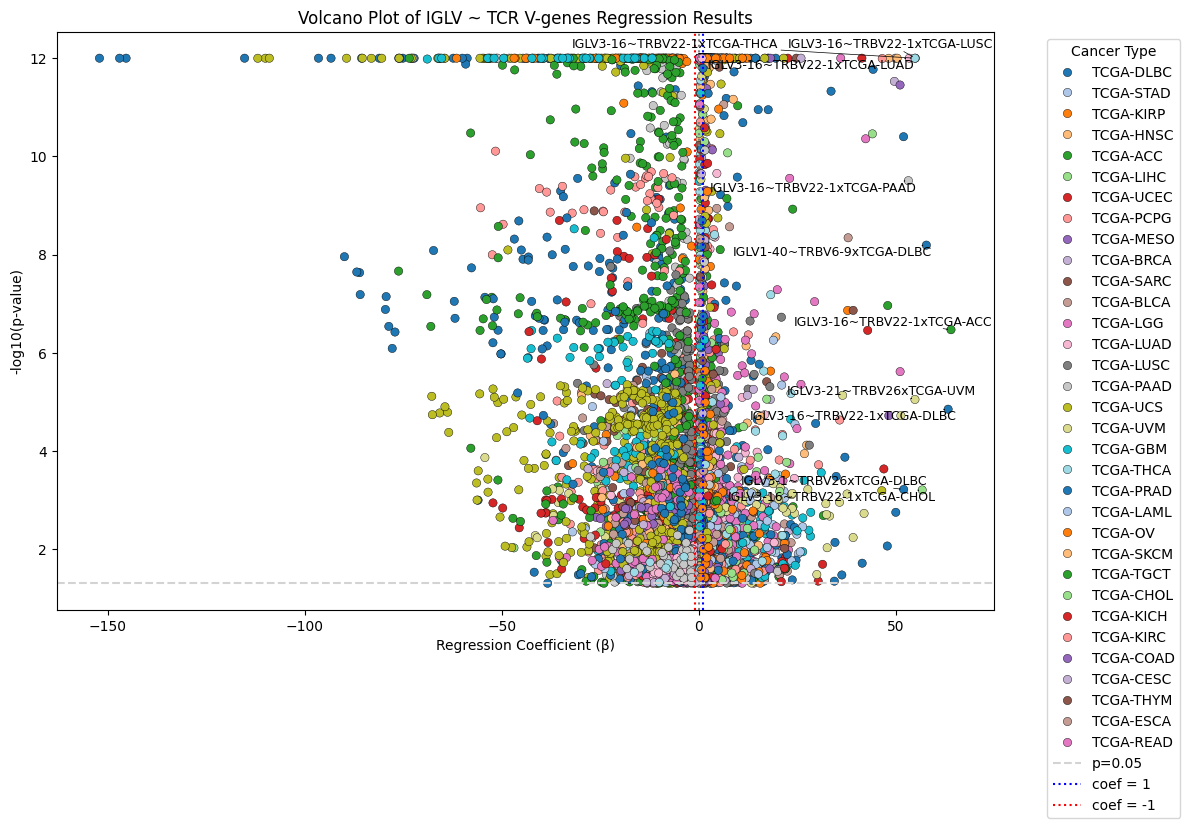

In [52]:
df = iglv_regr.copy()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="coef", y="-log10(p-value)", hue="TCGA_predictor", palette="tab20", edgecolor="black", linewidth=0.3)

plt.axhline(-np.log10(0.05), color="lightgrey", linestyle="dashed", label="p=0.05")
plt.axvline(0, color="grey", linestyle="dotted")
plt.axvline(1, color="blue", linestyle="dotted", label="coef = 1")
plt.axvline(-1, color="red", linestyle="dotted", label="coef = -1")

plt.xlabel("Regression Coefficient (β)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot of IGLV ~ TCR V-genes Regression Results")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cancer Type")

df_top10 = df.nlargest(10, "coef")
df_top1_cancer = df.sort_values("coef", ascending=False).groupby("TCGA_predictor").head(1)

highlight = pd.concat([df_top10, df_top1_cancer]).drop_duplicates()

texts = []
for i, row in df_top10.iterrows():
    label = f"{row['dependent_var']}~{row['gene_predictor']}x{row['TCGA_predictor']}"
    texts.append(
        plt.text(row["coef"], row["-log10(p-value)"], label, fontsize=9, ha='right')
    )

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))
plt.savefig("plots/regression_plots/volcano_plot_IGLV_TCR.png", dpi=300, bbox_inches='tight') 
plt.tight_layout()
plt.show()

- IGK V genes isotypes ~ TCR V gene x TCGA project

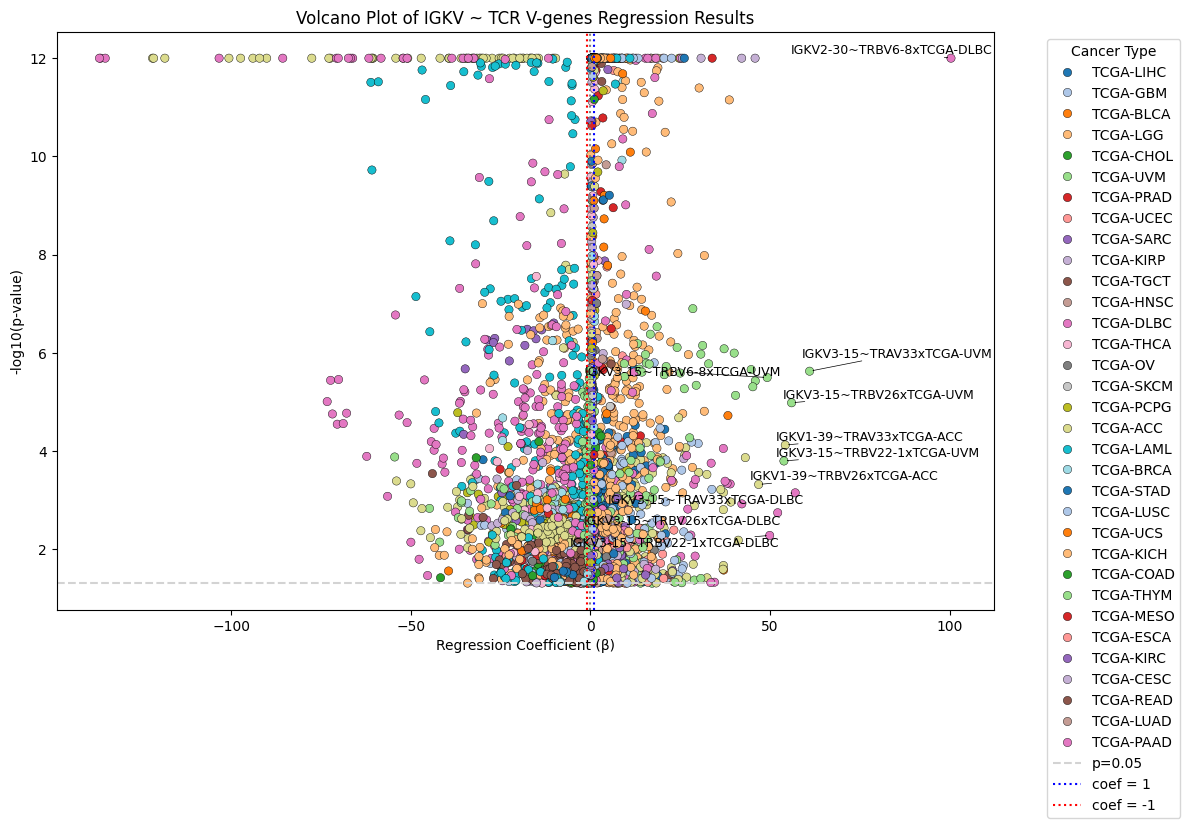

In [53]:
df = igkv_regr.copy()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x="coef", y="-log10(p-value)", hue="TCGA_predictor", palette="tab20", edgecolor="black", linewidth=0.3)

plt.axhline(-np.log10(0.05), color="lightgrey", linestyle="dashed", label="p=0.05")
plt.axvline(0, color="grey", linestyle="dotted")
plt.axvline(1, color="blue", linestyle="dotted", label="coef = 1")
plt.axvline(-1, color="red", linestyle="dotted", label="coef = -1")

plt.xlabel("Regression Coefficient (β)")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot of IGKV ~ TCR V-genes Regression Results")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cancer Type")

df_top10 = df.nlargest(10, "coef")
df_top1_cancer = df.sort_values("coef", ascending=False).groupby("TCGA_predictor").head(1)

highlight = pd.concat([df_top10, df_top1_cancer]).drop_duplicates()

texts = []
for i, row in df_top10.iterrows():
    label = f"{row['dependent_var']}~{row['gene_predictor']}x{row['TCGA_predictor']}"
    texts.append(
        plt.text(row["coef"], row["-log10(p-value)"], label, fontsize=9, ha='right')
    )

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))
plt.savefig("plots/regression_plots/volcano_plot_IGKV_TCR.png", dpi=300, bbox_inches='tight') 
plt.tight_layout()
plt.show()

# **Gene distributions inside TCGA projects**

In [57]:
def plot_top_genes_in_cancer_type(df, cancer_type, sort_by="median", top_n=30, transform="log1p"):
    df = df.copy()
    gene_cols = [col for col in df.columns if col not in ["sample", "project_id"]]
    subset = df[df["project_id"] == cancer_type][gene_cols]
    if transform == "log1p":
        subset = np.log1p(subset * 1000)
    elif transform == "log10":
        subset = np.log10(subset * 1000 + 1)
    elif transform == "sqrt":
        subset = np.sqrt(subset * 1000)

    if sort_by == "median":
        scores = subset.median().sort_values(ascending=False)
    elif sort_by == "mean":
        scores = subset.mean().sort_values(ascending=False)
    elif sort_by == "entropy":
        scores = subset.apply(lambda x: entropy(np.histogram(x, bins=30, density=True)[0] + 1e-9)).sort_values(ascending=False)
    elif sort_by == "nonzero":
        scores = (subset > 0).sum().sort_values(ascending=False)

    top_genes = scores.head(top_n).index.tolist()

    melted = subset[top_genes].melt(var_name="Gene", value_name="Transformed expression")
    order = scores.head(top_n).index

    plt.figure(figsize=(10, 6))
    sns.violinplot(data=melted, x="Gene", y="Transformed expression", order=order,
                   palette="Spectral", cut=0, inner="box", linewidth=1)
    plt.title(f"Top {top_n} genes in {cancer_type} (sorted by {sort_by})", fontsize=14)
    plt.xticks(rotation=80)
    plt.tight_layout()
    plt.show()


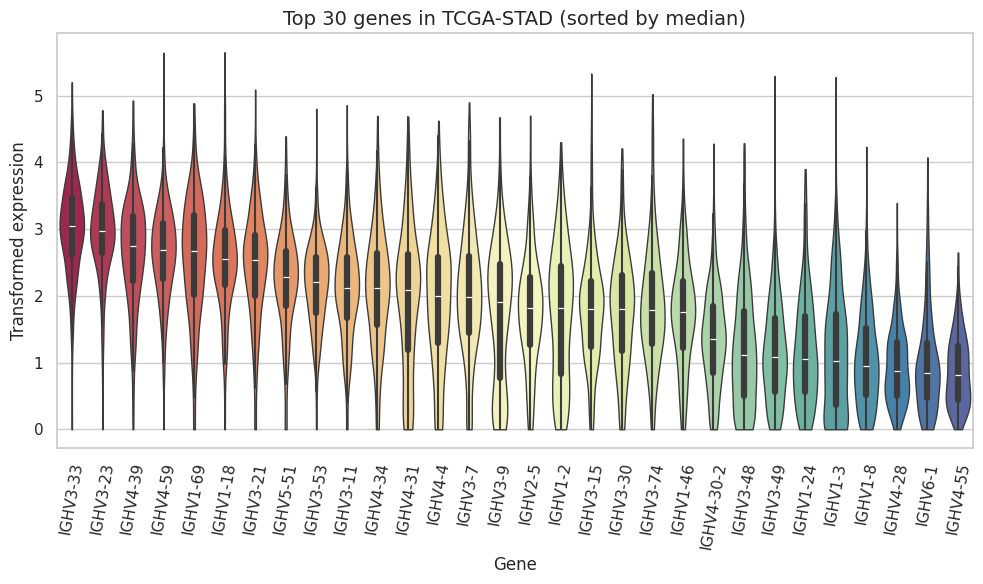

In [58]:
plot_top_genes_in_cancer_type(ighv_df, "TCGA-STAD", sort_by="median")

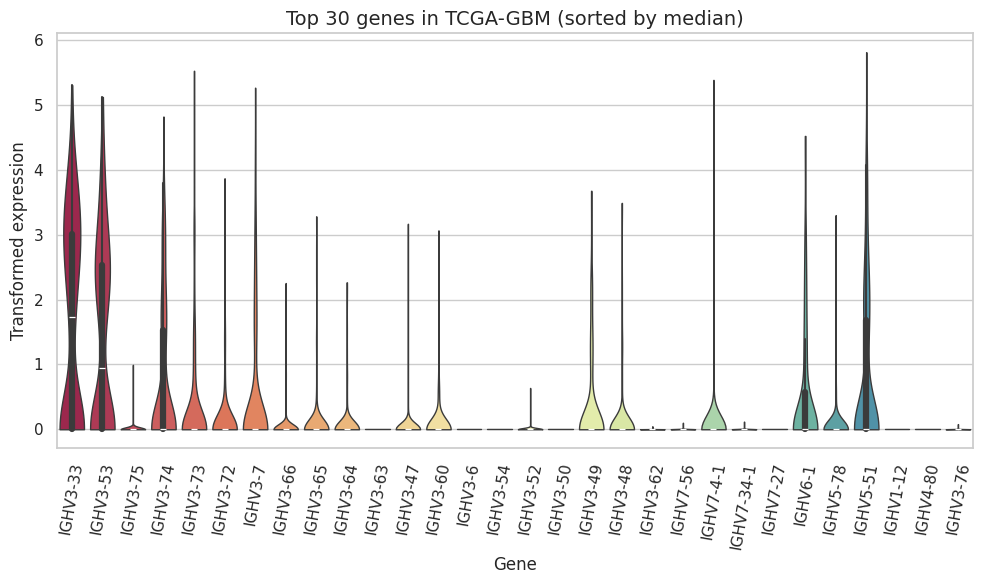

In [59]:
plot_top_genes_in_cancer_type(ighv_df, "TCGA-GBM", sort_by="median")

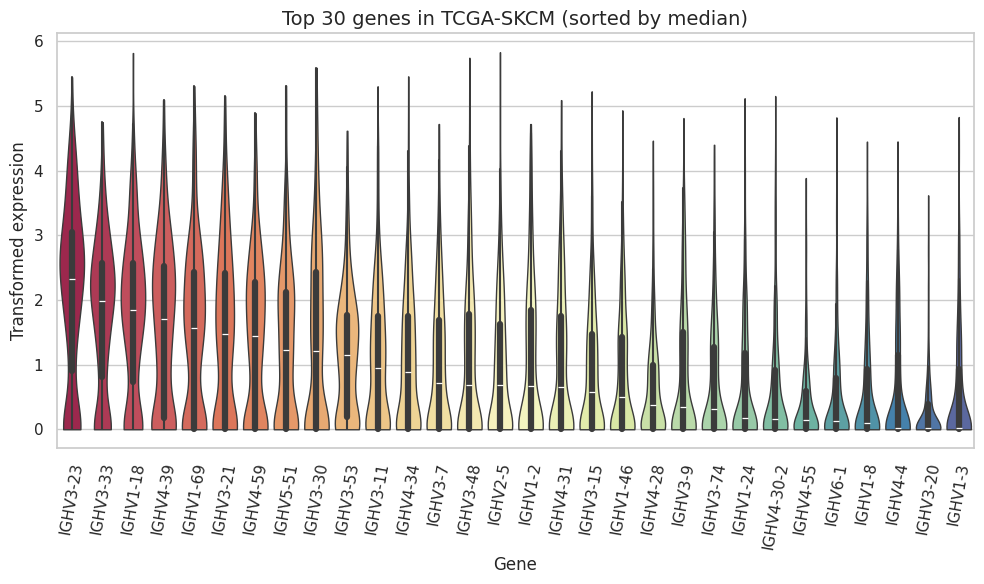

In [60]:
plot_top_genes_in_cancer_type(ighv_df, "TCGA-SKCM", sort_by="median")